# Plotting the graph

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import sys,shutil
from pathlib import Path

import scipy.optimize as syopt
import scipy.special as sysp



import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc
from time import time

# These imports needed for MCMC using Cobaya
from cobaya.yaml import yaml_load_file
from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya,MCSamples
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

from scipy.optimize import curve_fit

# from polynomials import Polynomials  # imports from ./polynomials.py
# from paths import ML_Path

sys.path.append('../../code/')  # now okay
# sys.path.append(ML_Path)



# import utilities



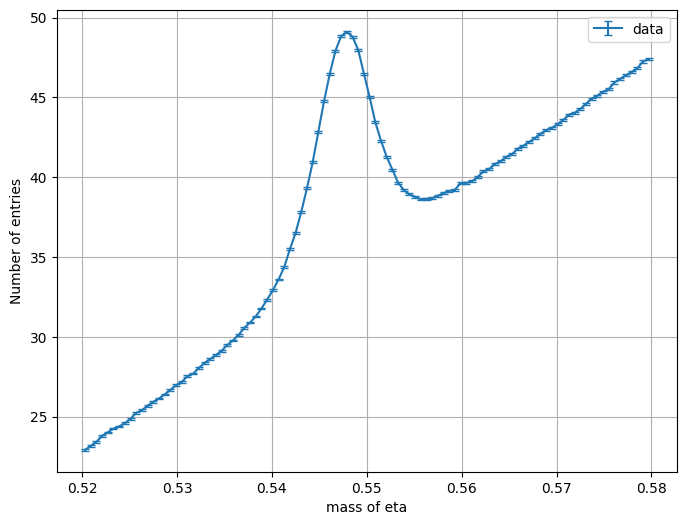

100

In [28]:

df = pd.read_csv("TotalStackedNote.csv")

x = df['bin_center']
y = df['content']
err = df['error']
y = y / 1e4
err = err / 1e4
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")

plt.grid()
plt.legend()
plt.ylabel("Number of entries")
plt.xlabel("mass of eta")
plt.show()
len(x)

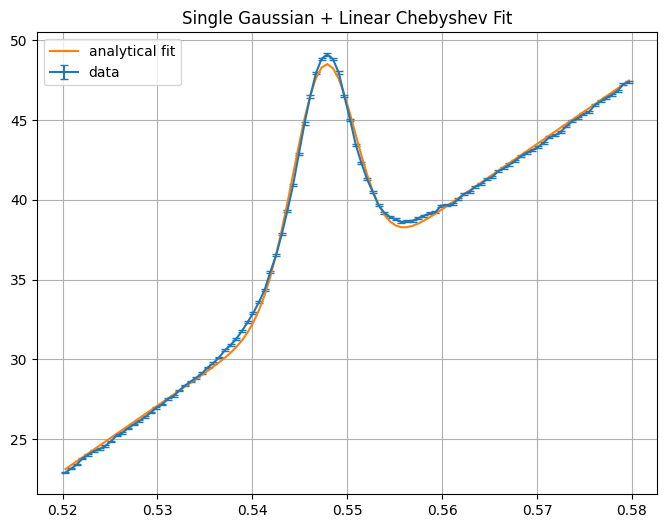

Chi-squared: 2096.456473142671
Degrees of freedom: 95
p-value: 0.0
AICc: 2107.0947710150112


In [33]:
def single(x, *gaussCheby):
    A1, mu1,sig1,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ + cheby

singleparam, _ = curve_fit(single,x,y,sigma=err, absolute_sigma=True,p0 = [12, .547, 0.01, 12.5, 500])
def chi2(y, data, sigma,x):
    chi = np.sum(((data-y)/sigma)**2)
    dof = len(x) - 8
    return chi

from scipy.stats import chi2 as chi2_dist

chi2_val = chi2(y, single(x,  *singleparam), err, x)
dof = len(x) - len(singleparam)

p_value = chi2_dist.sf(chi2_val, dof)  # This gives the p-value
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")
plt.plot(x, single(x,*singleparam), label = "analytical fit")
plt.title("Single Gaussian + Linear Chebyshev Fit")

plt.grid()
plt.legend()
plt.show()
print("Chi-squared:", chi2_val)
print("Degrees of freedom:", dof)
print("p-value:", p_value)
# Compute AIC and AICc
m = len(singleparam)  # Number of parameters in triplegauss
n = len(x)            # Number of data points


aicc = chi2_val + (2 * m * n) / (n - m - 1)

print("AICc:", aicc)

# Analytical Solution

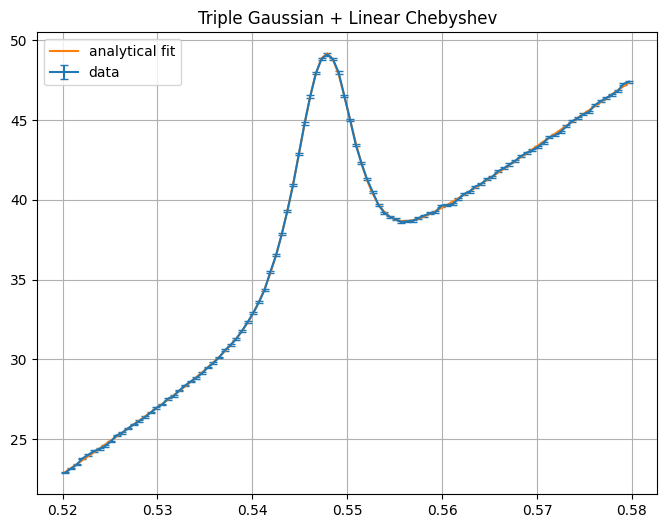

Chi-squared: 92.32497535903211
Degrees of freedom: 89
p-value: 0.38360665858721454
AICc: 117.32497535903211


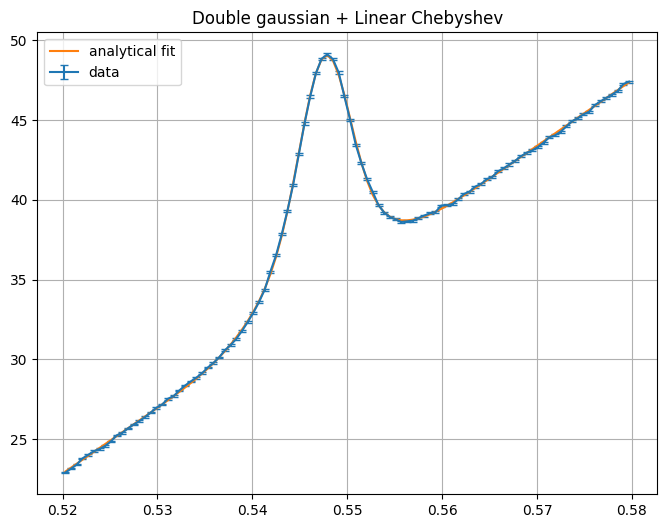

Chi-squared: 148.61037575650715
Degrees of freedom: 92
p-value: 0.00017078328935597417
AICc: 166.19279333892473


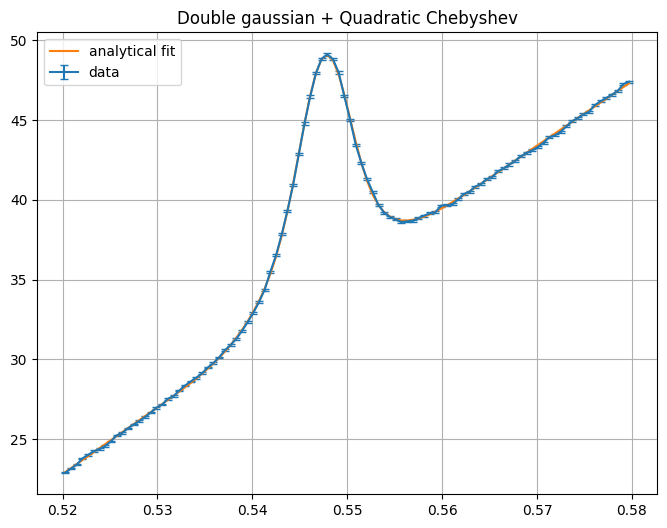

Chi-squared: 138.1197945066863
Degrees of freedom: 91
p-value: 0.0010620117028338836
AICc: 158.1197945066863


In [34]:
def model(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))  # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ gauss2 + cheby

def triplegauss(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,A3, mu3, sig3,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))
    gauss3 = A3 * np.exp(-((x - mu3)**2) / (2 * sig3**2))  # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ gauss2 + cheby + gauss3


params, param_cov = curve_fit(model, x, y, sigma=err, absolute_sigma=True, p0 = [12, .547, 0.01, 10, .548, .005, 12.5, 500]
)

paramtriple, param_cov_triple = curve_fit(triplegauss, x, y, sigma=err, absolute_sigma=True, p0 = [12, .547, 0.01, 10, .548, .005,7,.546,0.007, 12.5, 500],bounds = (
    [0, 0.54, 0, 0, 0.54, 0, 0, 0.54, 0, -np.inf, -np.inf],  # lower
    [np.inf, 0.56, 0.02, np.inf, 0.56, 0.02, np.inf, 0.56, 0.02, np.inf, np.inf]  # upper
), maxfev=20000)
# print(params)
# print("paramcov",param_cov)
# print("paramcov daigonal",param_cov.diagonal())


plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")
plt.plot(x, triplegauss(x,*paramtriple), label = "analytical fit")
plt.title("Triple Gaussian + Linear Chebyshev")

plt.grid()
plt.legend()
plt.show()

def chi2(y, data, sigma,x):
    chi = np.sum(((data-y)/sigma)**2)
    dof = len(x) - 8
    return chi

from scipy.stats import chi2 as chi2_dist

chi2_val = chi2(y, triplegauss(x,  *paramtriple), err, x)
dof = len(x) - len(paramtriple)

p_value = chi2_dist.sf(chi2_val, dof)  # This gives the p-value

print("Chi-squared:", chi2_val)
print("Degrees of freedom:", dof)
print("p-value:", p_value)
# Compute AIC and AICc
m = len(paramtriple)  # Number of parameters in triplegauss
n = len(x)            # Number of data points


aicc = chi2_val + (2 * m * n) / (n - m - 1)

print("AICc:", aicc)









# double fit
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")
plt.plot(x, model(x,*params), label = "analytical fit")
plt.title("Double gaussian + Linear Chebyshev")

plt.grid()
plt.legend()
plt.show()


chi2_val = chi2(y, model(x,  *params), err, x)
dof = len(x) - len(params)

p_value = chi2_dist.sf(chi2_val, dof)  # This gives the p-value

print("Chi-squared:", chi2_val)
print("Degrees of freedom:", dof)
print("p-value:", p_value)
# Compute AIC and AICc
m = len(params)  # Number of parameters in triplegauss
n = len(x)            # Number of data points


aicc = chi2_val + (2 * m * n) / (n - m - 1)

print("AICc:", aicc)








#triple quadratic
def triplequad(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,a0, a1, a2 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))
     # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x + a2*x**2
    
    return gauss1+ gauss2 + cheby 


paramquad, param_cov_quad= curve_fit(triplequad, x, y, sigma=err, absolute_sigma=True, p0 = [12, .547, 0.01, 10, .548, .005, 12.5, 500, 1], maxfev=20000)

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")
plt.plot(x, triplequad(x,*paramquad), label = "analytical fit")
plt.title("Double gaussian + Quadratic Chebyshev")

plt.grid()
plt.legend()
plt.show()


chi2_val = chi2(y, triplequad(x,  *paramquad), err, x)
dof = len(x) - len(paramquad)

p_value = chi2_dist.sf(chi2_val, dof)  # This gives the p-value

print("Chi-squared:", chi2_val)
print("Degrees of freedom:", dof)
print("p-value:", p_value)
# Compute AIC and AICc
m = len(paramquad)  # Number of parameters in triplegauss
n = len(x)            # Number of data points


aicc = chi2_val + (2 * m * n) / (n - m - 1)

print("AICc:", aicc)


In [5]:
variances = err**2
cov = np.diag(variances)
cov 

array([[0.00229126, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00231572, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0023411 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00468209, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00472483,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00474039]], shape=(100, 100))

In [6]:
# import utilities
# utilities.svd_inv(cov)

# MCMC

In [7]:
# # doublegausu
# import likelihood

# dim = 8

# Run_Cobaya = True
# Show_Cobaya = True
# Resume = False

# Max_Samples = 100000
# Rminus1_Stop = 0.01 
# Rminus1_CL_Stop = 0.05
# Rminus1_CL_Level = 0.99
# Burn_In = 0

# Latex_List = []
# Params_List = []
# for m in range(dim):
#     Latex_List.append('a_{'+str(m)+'}') 
#     Params_List.append('a'+str(m))

# print(Latex_List)
# info = {}
# info['likelihood'] = {'likelihood.Chi2Like':
#                       {'python_path':'./',
#                        'data':y,
#                        'cov_mat':cov}}

# info['theory'] = {'likelihood.GaussChebyTheory2':
#                   {'python_path':'./',
#                    'xvals':x}}

# info['params'] = {}


# info['params']['a0'] = {
#     'ref': 12,                                # Inside [-2, 2]
#     'prior': {'min': 0, 'max': 20},
#     'proposal': .1,
#     'latex': 'a_{0}'
# }

# info['params']['a1'] = {
#     'ref': .547,                                # Inside [-2, 2]
#     'prior': {'min': .52, 'max': .56},
#     'proposal': .001,
#     'latex': 'a_{1}'
# }
# info['params']['a2'] = {
#     'ref': .01,                                # Inside [-2, 2]
#     'prior': {'min':.0001, 'max': .1},
#     'proposal': .001,
#     'latex': 'a_{2}'
# }
# info['params']['a3'] = {
#     'ref': 10,                                # Inside [-2, 2]
#     'prior': {'min': 0, 'max': 20},
#     'proposal': .1,
#     'latex': 'a_{3}'
# }
# info['params']['a4'] = {
#     'ref': .548,                                # Inside [-2, 2]
#     'prior': {'min':.52, 'max': .56},
#     'proposal': .001,
#     'latex': 'a_{4}'
# }
# info['params']['a5'] = {
#     'ref': .005,                                # Inside [-2, 2]
#     'prior': {'min':.0001, 'max': .1},
#     'proposal': .001,
#     'latex': 'a_{5}'
# }
# info['params']['a6'] = {
#     'ref': 12.5,                                # Inside [-2, 2]
#     'prior': {'min':-200, 'max': 100},
#     'proposal': .5,
#     'latex': 'a_{6}'
# }
# info['params']['a7'] = {
#     'ref': 500,                                # Inside [-2, 2]
#     'prior': {'min':100, 'max': 600},
#     'proposal': .5,
#     'latex': 'a_{7}'
# }






# info['sampler'] = {'mcmc':
#                    {'learn_proposal': True,
#                     'Rminus1_single_split': 4,
#                     'measure_speeds': True,
#                     'max_samples': Max_Samples,
#                     'max_tries': 10000,
#                     'Rminus1_stop': Rminus1_Stop,
#                     'Rminus1_cl_stop': Rminus1_CL_Stop,
#                     'Rminus1_cl_level': Rminus1_CL_Level,
#                     'burn_in': Burn_In}}

# info['output'] = 'stats/chains/eta/poly_deg{0:d}'.format(dim-1)
# if Resume:
#     info["resume"] = True
# else:
#     info["force"] = True
# print('... done with setup')


['a_{0}', 'a_{1}', 'a_{2}', 'a_{3}', 'a_{4}', 'a_{5}', 'a_{6}', 'a_{7}']
... done with setup


In [8]:
#triple gauss
import likelihood

dim = len(paramtriple)

Run_Cobaya = True
Show_Cobaya = True
Resume = False

Max_Samples = 100000
Rminus1_Stop = 0.01 
Rminus1_CL_Stop = 0.05
Rminus1_CL_Level = 0.99
Burn_In = 0

Latex_List = []
Params_List = []
for m in range(dim):
    Latex_List.append('a_{'+str(m)+'}') 
    Params_List.append('a'+str(m))

print(Latex_List)
info = {}
info['likelihood'] = {'likelihood.Chi2Like':
                      {'python_path':'./',
                       'data':y,
                       'cov_mat':cov}}

info['theory'] = {'likelihood.GaussChebyTheory3':
                  {'python_path':'./',
                   'xvals':x}}

info['params'] = {}


info['params']['a0'] = {
    'ref': 12,                                # Inside [-2, 2]
    'prior': {'min': 0, 'max': 20},
    'proposal': .1,
    'latex': 'a_{0}'
}

info['params']['a1'] = {
    'ref': .547,                                # Inside [-2, 2]
    'prior': {'min': .52, 'max': .56},
    'proposal': .001,
    'latex': 'a_{1}'
}
info['params']['a2'] = {
    'ref': .01,                                # Inside [-2, 2]
    'prior': {'min':.0001, 'max': .1},
    'proposal': .001,
    'latex': 'a_{2}'
}
info['params']['a3'] = {
    'ref': 10,                                # Inside [-2, 2]
    'prior': {'min': 0, 'max': 20},
    'proposal': .1,
    'latex': 'a_{3}'
}
info['params']['a4'] = {
    'ref': .548,                                # Inside [-2, 2]
    'prior': {'min':.52, 'max': .56},
    'proposal': .001,
    'latex': 'a_{4}'
}
info['params']['a5'] = {
    'ref': .005,                                # Inside [-2, 2]
    'prior': {'min':.0001, 'max': .1},
    'proposal': .001,
    'latex': 'a_{5}'
}
info['params']['a6'] = {
    'ref': 7,                                # Inside [-2, 2]
    'prior': {'min': 0, 'max': 20},
    'proposal': .1,
    'latex': 'a_{6}'
}
info['params']['a7'] = {
    'ref': .5475,                                # Inside [-2, 2]
    'prior': {'min':.52, 'max': .56},
    'proposal': .001,
    'latex': 'a_{7}'
}
info['params']['a8'] = {
    'ref': .006,                                # Inside [-2, 2]
    'prior': {'min':.0001, 'max': .1},
    'proposal': .001,
    'latex': 'a_{8}'
}
info['params']['a9'] = {
    'ref': 12.5,                                # Inside [-2, 2]
    'prior': {'min':-200, 'max': 100},
    'proposal': .5,
    'latex': 'a_{9}'
}
info['params']['a10'] = {
    'ref': 500,                                # Inside [-2, 2]
    'prior': {'min':100, 'max': 600},
    'proposal': .5,
    'latex': 'a_{10}'
}








info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 10000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}

info['output'] = 'stats/chains/eta/poly_deg{0:d}'.format(dim-1)
if Resume:
    info["resume"] = True
else:
    info["force"] = True
print('... done with setup')


['a_{0}', 'a_{1}', 'a_{2}', 'a_{3}', 'a_{4}', 'a_{5}', 'a_{6}', 'a_{7}', 'a_{8}', 'a_{9}', 'a_{10}']
... done with setup


In [9]:
Run_Cobaya = True  # or False

if Run_Cobaya:
    start_time = time()
    
    updated_info, sampler = run(info)
    

[output] Output to be read-from/written-into folder 'stats/chains/eta', with prefix 'poly_deg10'
[output] Found existing info files with the requested output prefix: 'stats/chains/eta/poly_deg10'
[output] Will delete previous products ('force' was requested).
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: a0:12, a1:0.547, a2:0.01, a3:10, a4:0.548, a5:0.005, a6:7, a7:0.5475, a8:0.006, a9:12.5, a10:500
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {likelihood.Chi2Like: 5150.0, likelihood.GaussChebyTheory3: 1210.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-07-18 13:35:55 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 440 samples accepted.
[mcmc]  - Acceptance rate: 0.170
[mcmc]  - Convergence of means: R-1 = 50.963413 after 352 accepted s

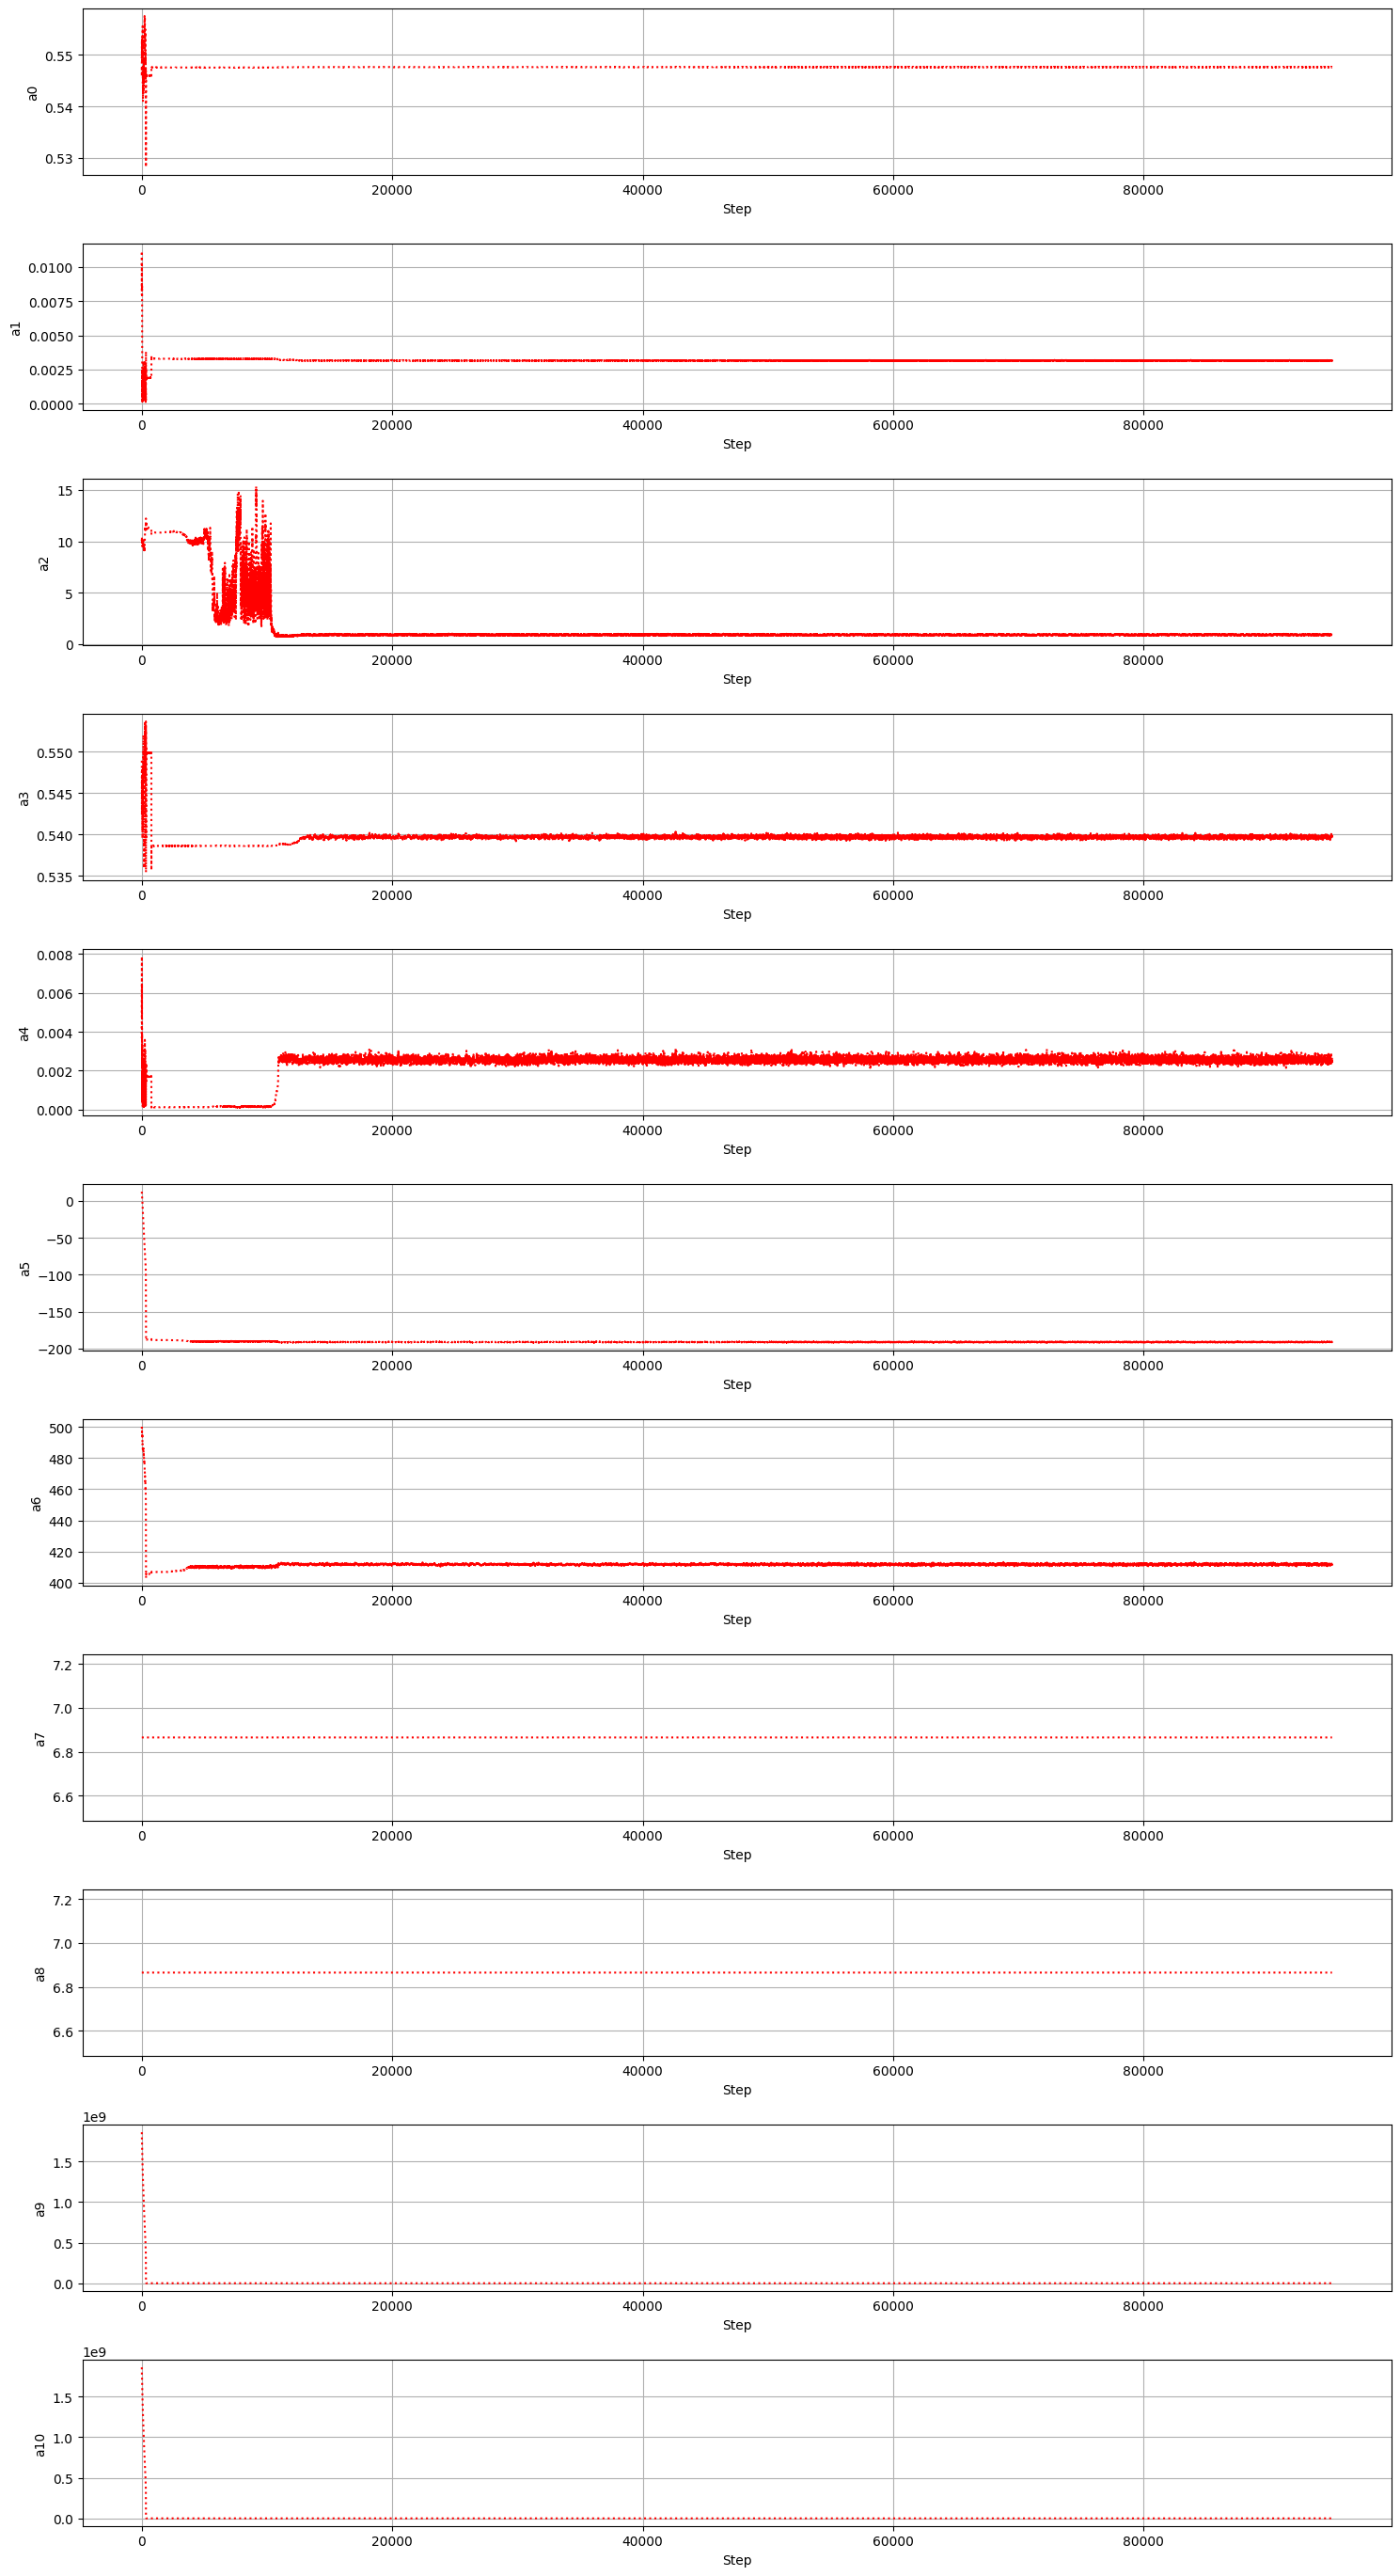

Last accepted parameter values:
a0 = 0.54764253
a1 = 0.0031398655
a2 = 0.9343838
a3 = 0.5397696
a4 = 0.0024782343
a5 = -191.3526
a6 = 412.00787
a7 = 6.8649323
a8 = 6.8649323
a9 = 1004.891
a10 = 1004.891


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Load the chain, skipping the header
filename = "stats/chains/eta/poly_deg7.1.txt"

# Find how many header lines start with "#"
with open(filename, 'r') as f:
    header_lines = 0
    for line in f:
        if line.startswith('#'):
            header_lines += 1
        else:
            break

# Load the data
data = np.loadtxt(filename, skiprows=header_lines)

# Column index map (based on your screenshot)
columns = {
    "weight": 1,
    "minuslogpost": 2,
    "a0": 3,
    "a1": 4,
    "a2": 5,
    "a3": 6,
    "a4": 7,
    "a5":8,
    "a6":9,
    "a7":10,
    "a8":11,
    "a9":12,
    "a10":13,
    "minuslogprior": 8
}

# List of parameters you want to plot
params_text = ["a0", "a1", "a2", "a3", "a4","a5","a6", "a7","a8","a9", "a10"]

# Plot each parameter vs steps
plt.figure(figsize=(15, 2.5 * len(params_text)))
for i, p in enumerate(params_text):
    plt.subplot(len(params_text), 1, i + 1)
    plt.plot(data[:, columns[p]], "r:")
    # plt.xlim((150000,175000))
    plt.ylabel(p)
    plt.xlabel("Step")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print last accepted value of each parameter
print("Last accepted parameter values:")
for p in params_text:
    print(f"{p} = {data[-1, columns[p]]}")


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples
import gc
from time import time


ncomp = dim // 2        # number of (a, b) pairs




# MCMC plotting and analysis
Show_Cobaya = True
Burn_In = 0.2  # or 0.3, depending on your setup

# Replace this with your actual Cobaya output info
info = {
    "output": 'stats/chains/eta/poly_deg{0:d}'.format(dim-1) # assumes files like mysim.1.txt, mysim.info exist
}

FS1, FS2, FS3 = 16, 14, 12  # Font sizes

if Show_Cobaya:
    start_time = time()
    
    # Load GetDist MCMC samples
    gd_sample = loadMCSamples(info["output"], settings={'ignore_rows': Burn_In})
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    
    # Load raw MCMC samples
    sample = np.loadtxt(info["output"] + '.1.txt')
    sample = sample[int(Burn_In * sample.shape[0]):]  # remove burn-in
    sample = sample.T
    
    ibest = sample[1].argmin()  # best-fit index (lowest -lnlike)
    mcmc_best = sample[2:2+dim, ibest]
    mcmc_chi2 = sample[dim+4, ibest]
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    
    print('MCMC results:')
    print(f"... best fit (a,b pairs): " + ", ".join(f"{v:.4f}" for v in mcmc_best))
    print(f"... std dev           : " + ", ".join(f"{v:.4f}" for v in mcmc_sig))
    print(f"... best chi2: {mcmc_chi2:.3f}")



    # Bootstrap confidence bands
    Nsample = gd_sample.samples.shape[0]
    N_boot = min(1000, int(0.2 * sample[0].size))
    poly_boot = np.zeros((N_boot, x.size))
    
    rng = np.random.default_rng(seed=42)
    indices = rng.choice(Nsample, size=N_boot, replace=False)
    
    for i, idx in enumerate(indices):
        params_i = sample[2:2+dim, idx]
        poly_boot[i] = triplegauss(x, *params_i)
    
    poly_16pc = np.percentile(poly_boot, 16, axis=0)
    poly_84pc = np.percentile(poly_boot, 84, axis=0)
    
    del poly_boot
    gc.collect()


    # plt.errorbar(x, y, yerr=err, fmt='o', ms=5, lw=1, capsize=4, label='Data', color='black')
    # plt.plot(x, y, ls=':', color='gray', lw=2, label='True model')
    # plt.plot(x, model(x, *mcmc_best), ls='-', color='indigo', lw=2, alpha=0.8, label='MCMC best fit')
  
    
    # plt.xlabel('$x$', fontsize=FS1)
    # plt.ylabel('$y(x)$', fontsize=FS1)
    # plt.title(f'eta fit ', fontsize=FS1)
    # plt.legend(fontsize=FS2)
    # # plt.ylim((4,5))
    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()
print("curvefit chi2")
def model(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))  # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ gauss2 + cheby

params = [4.72631805e+00,5.47194515e-01,5.03924494e-03,1.01220330e+01,5.47667469e-01,2.53761525e-03,-1.90634798e+02,4.10553062e+02]
y_curve_fit = model(x, *params)

def chi2(data,y,sig):
    dof = len(x)- 8
    chi = np.sum(((data-y)/err)**2)
    return chi

residuals = y - model(x, *params)
noise_sigma = np.std(residuals, ddof=1)

print(chi2(y, y_curve_fit, noise_sigma))

MCMC results:
... best fit (a,b pairs): 1.7443, 0.5469, 0.0067, 8.9137, 0.5475, 0.0034, 4.3168, 0.5478, 0.0020, -190.7938, 410.7894
... std dev           : 0.4032, 0.0002, 0.0004, 0.8002, 0.0000, 0.0002, 1.0598, 0.0000, 0.0001, 0.2109, 0.3818
... best chi2: 93.279
curvefit chi2
148.61037576249606


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples
import gc
from time import time


ncomp = dim // 2        # number of (a, b) pairs




# MCMC plotting and analysis
Show_Cobaya = True
Burn_In = 0.2  # or 0.3, depending on your setup

# Replace this with your actual Cobaya output info
info = {
    "output": 'stats/chains/eta/poly_deg{0:d}'.format(dim-1) # assumes files like mysim.1.txt, mysim.info exist
}

FS1, FS2, FS3 = 16, 14, 12  # Font sizes

if Show_Cobaya:
    start_time = time()
    
    # Load GetDist MCMC samples
    gd_sample = loadMCSamples(info["output"], settings={'ignore_rows': Burn_In})
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    
    # Load raw MCMC samples
    sample = np.loadtxt(info["output"] + '.1.txt')
    sample = sample[int(Burn_In * sample.shape[0]):]  # remove burn-in
    sample = sample.T
    
    ibest = sample[1].argmin()  # best-fit index (lowest -lnlike)
    mcmc_best = sample[2:2+dim, ibest]
    mcmc_chi2 = sample[dim+4, ibest]
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    
    print('MCMC results:')
    print(f"... best fit (a,b pairs): " + ", ".join(f"{v:.4f}" for v in mcmc_best))
    print(f"... std dev           : " + ", ".join(f"{v:.4f}" for v in mcmc_sig))
    print(f"... best chi2: {mcmc_chi2:.3f}")



    # Bootstrap confidence bands
    Nsample = gd_sample.samples.shape[0]
    N_boot = min(1000, int(0.2 * sample[0].size))
    poly_boot = np.zeros((N_boot, x.size))
    
    rng = np.random.default_rng(seed=42)
    indices = rng.choice(Nsample, size=N_boot, replace=False)
    
    for i, idx in enumerate(indices):
        params_i = sample[2:2+dim, idx]
        poly_boot[i] = triplegauss(x, *params_i)
    
    poly_16pc = np.percentile(poly_boot, 16, axis=0)
    poly_84pc = np.percentile(poly_boot, 84, axis=0)
    
    del poly_boot
    gc.collect()


    # plt.errorbar(x, y, yerr=err, fmt='o', ms=5, lw=1, capsize=4, label='Data', color='black')
    # plt.plot(x, y, ls=':', color='gray', lw=2, label='True model')
    # plt.plot(x, model(x, *mcmc_best), ls='-', color='indigo', lw=2, alpha=0.8, label='MCMC best fit')
  
    
    # plt.xlabel('$x$', fontsize=FS1)
    # plt.ylabel('$y(x)$', fontsize=FS1)
    # plt.title(f'eta fit ', fontsize=FS1)
    # plt.legend(fontsize=FS2)
    # # plt.ylim((4,5))
    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()
print("curvefit chi2")
def model(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))  # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ gauss2 + cheby

params = [4.72631805e+00,5.47194515e-01,5.03924494e-03,1.01220330e+01,5.47667469e-01,2.53761525e-03,-1.90634798e+02,4.10553062e+02]
y_curve_fit = model(x, *params)

def chi2(data,y,sig):
    dof = len(x)- 8
    chi = np.sum(((data-y)/err)**2)
    return chi

residuals = y - model(x, *params)
noise_sigma = np.std(residuals, ddof=1)

print(chi2(y, y_curve_fit, noise_sigma))

MCMC results:
... best fit (a,b pairs): 1.7443, 0.5469, 0.0067, 8.9137, 0.5475, 0.0034, 4.3168, 0.5478, 0.0020, -190.7938, 410.7894
... std dev           : 0.4032, 0.0002, 0.0004, 0.8002, 0.0000, 0.0002, 1.0598, 0.0000, 0.0001, 0.2109, 0.3818
... best chi2: 93.279
curvefit chi2
148.61037576249606


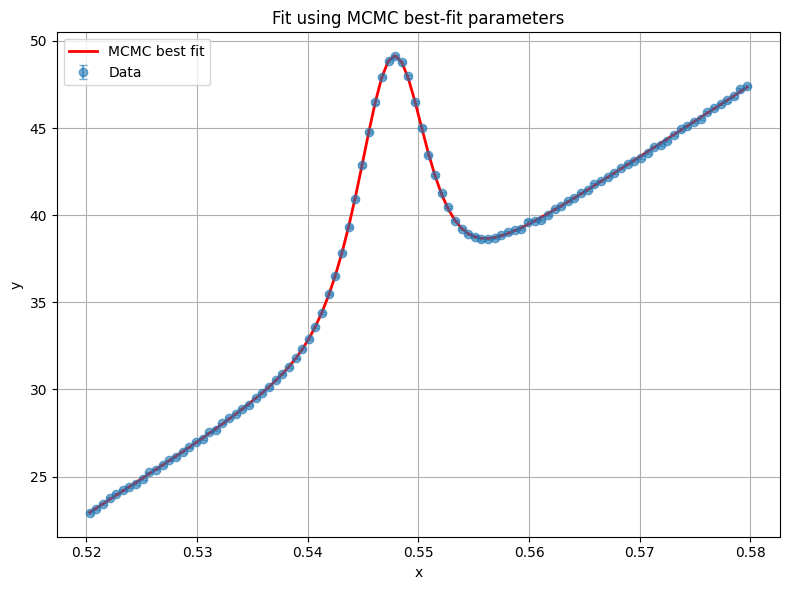

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Original data (replace with your real arrays)
# x = np.array([...])
# y = np.array([...])
# err = np.array([...])

# # MCMC best fit values from the image
# params_mcmc = [13.1097, 0.5475, 0.0031, 1.3179, 0.5465, 0.0086, -191.9483, 412.7886]
# # MCMC standard deviations (1σ uncertainties)
# errors_mcmc = [0.4540, 0.0001, 0.0001, 4.3729, 0.0095, 0.0239, 4.3226, 9.6283]

def model(x, A1, mu1, sig1, A2, mu2, sig2, a0, a1):
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))
    cheby = a0 + a1 * x
    return gauss1 + gauss2 + cheby

# Generate best-fit model
y_fit = triplegauss(x, *mcmc_best)

# Plotting
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=err, fmt='o', capsize=3, label='Data', alpha=0.6)
plt.plot(x, y_fit, label='MCMC best fit', color='red', lw=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Fit using MCMC best-fit parameters")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


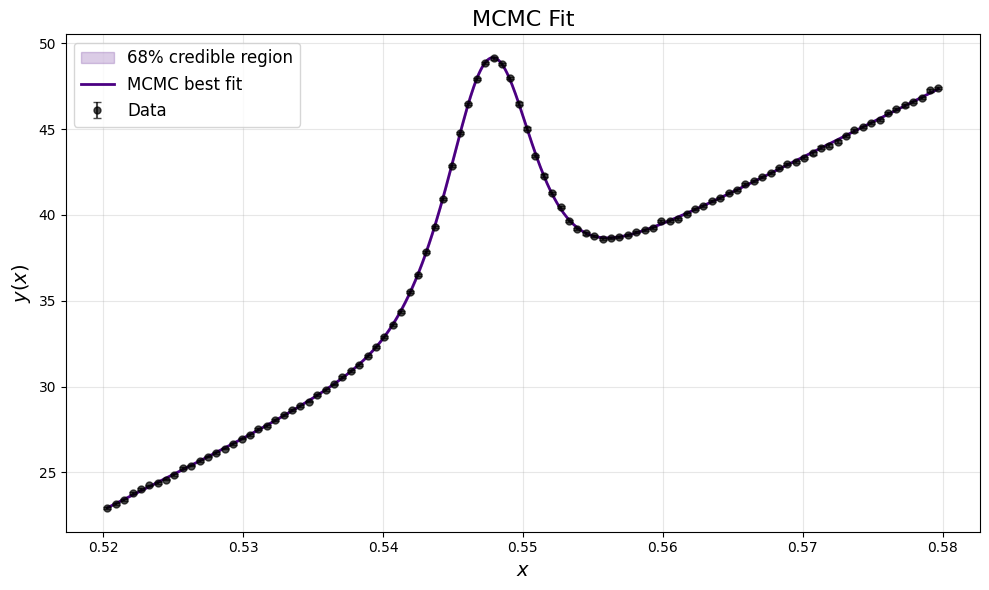

Chi-squared: 93.279068
Degrees of freedom: 89
p-value: 0.3573587349458562
AICc: 118.279068


In [38]:

mcmc_best_original = mcmc_best

# Rescale all samples for posterior prediction
samples_original = gd_sample.samples[:, :dim] 
# Generate predictions (using original-scale model)
x_plot = np.linspace(x.min(), x.max(), 500)
best_fit = triplegauss(x_plot, *mcmc_best_original)

# Posterior predictive (using a subset of samples)
predicted = np.array([triplegauss(x_plot, *params) for params in samples_original[:1000]])

# Calculate confidence bands
lower = np.percentile(predicted, 16, axis=0)
upper = np.percentile(predicted, 84, axis=0)

# Plotting
plt.figure(figsize=(10,6))
plt.fill_between(x_plot, lower, upper, color='indigo', alpha=0.2, 
                 label='68% credible region')
plt.plot(x_plot, best_fit, '-', color='indigo', lw=2, 
         label='MCMC best fit')
plt.errorbar(x, y, yerr=err, fmt='o', ms=5, capsize=3, 
             label='Data', color='black', alpha=0.7)




plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y(x)$', fontsize=14)
plt.title('MCMC Fit', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

def chi2(y, data, sigma,x):
    chi = np.sum(((data-y)/sigma)**2)
    dof = len(x) - 8
    return chi

from scipy.stats import chi2 as chi2_dist

chi2_val = mcmc_chi2
dof = len(x) - len(paramtriple)

p_value = chi2_dist.sf(chi2_val, dof)  # This gives the p-value

print("Chi-squared:", mcmc_chi2)
print("Degrees of freedom:", dof)
print("p-value:", p_value)
# Compute AIC and AICc
m = len(paramtriple)  # Number of parameters in triplegauss
n = len(x)            # Number of data points


aicc = chi2_val + (2 * m * n) / (n - m - 1)

print("AICc:", aicc)

[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a1. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a3. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a4, a5. Using fallback width: f(a) and f(b) must have different signs


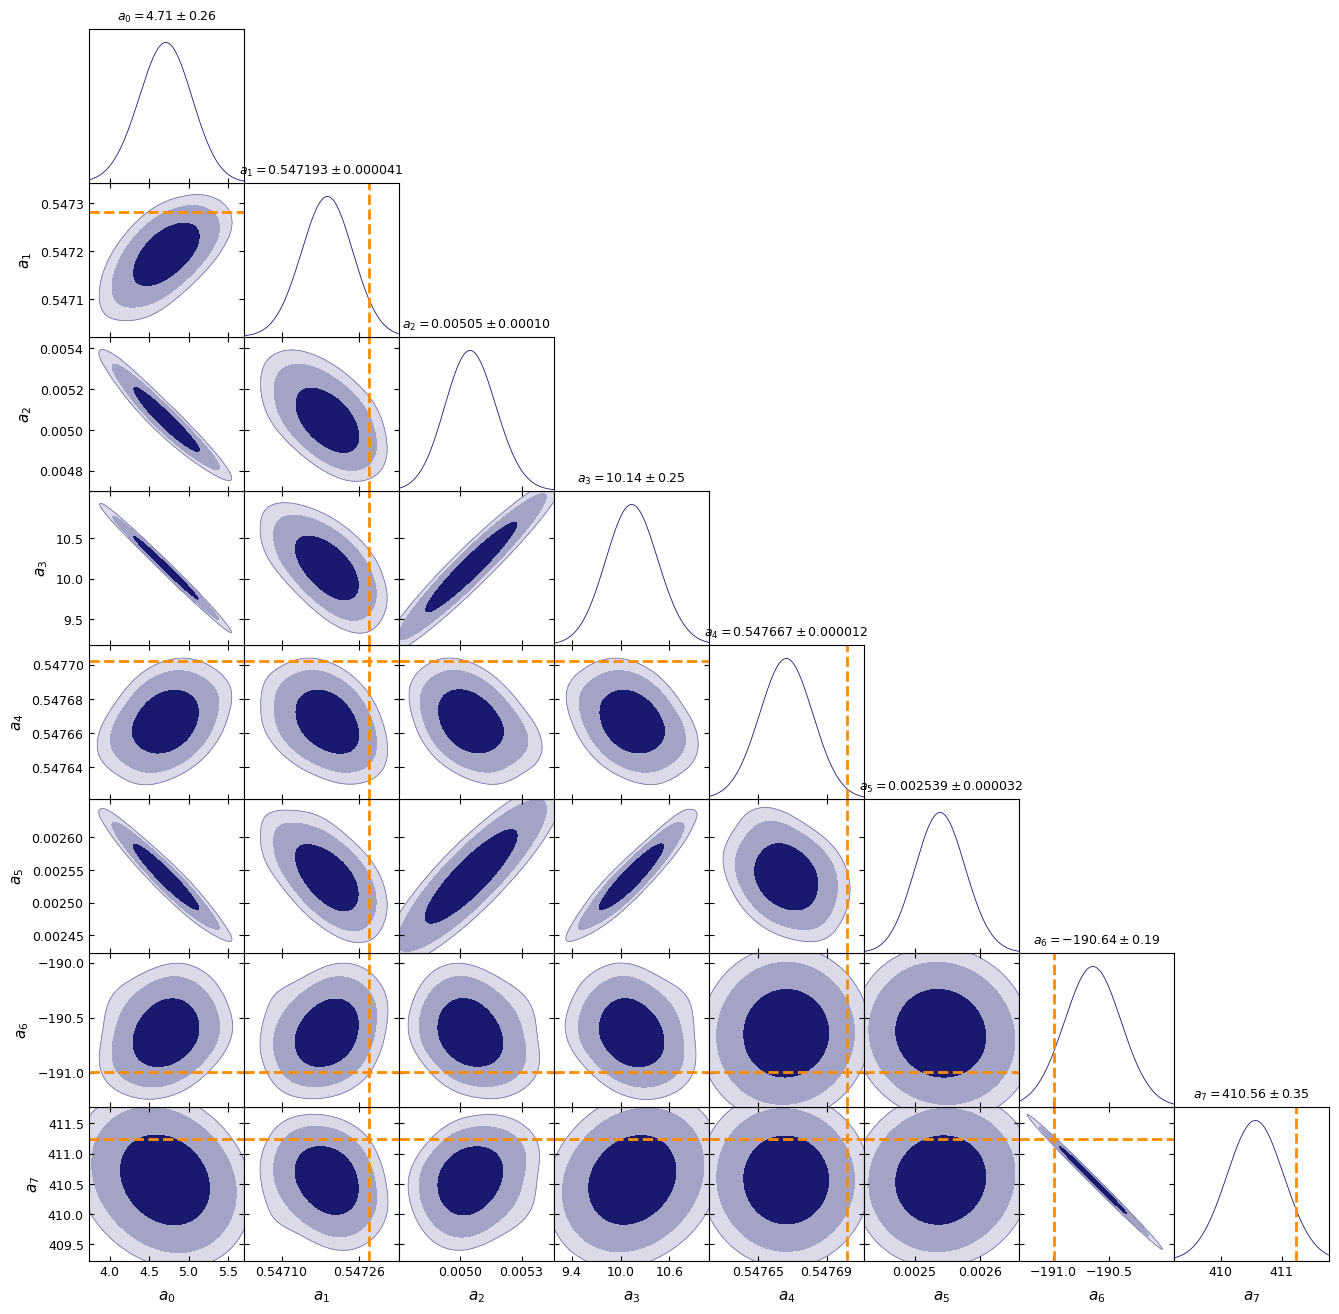

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples

# === Configuration ===
burn_in_fraction = 0.2  # discard initial 10% of samples
# params_list = ["a1", "mu1", "sig1", "a2", "mu2", "sig2", "a0", "a1"]
dim = len(Params_List)

# Update with your actual Cobaya output prefix (without `.txt` or `.yaml`)
output_prefix = "stats/chains/eta/poly_deg7"  # Change this if your chain is stored elsewhere

# Load the MCMC samples
samples = loadMCSamples(output_prefix, settings={'ignore_rows': burn_in_fraction})

# Optional: extract best-fit for marker placement
raw_chain = np.loadtxt(output_prefix + ".1.txt")
raw_chain = raw_chain[int(burn_in_fraction * raw_chain.shape[0]):]  # Apply burn-in
logpost = raw_chain[:, 1]  # log-posterior values
params = raw_chain[:, 2:2+dim]  # skip weight and logpost columns
best_index = np.argmax(logpost)
best_fit_params = params[best_index]

# Create triangle plot
plotter = gdplt.get_subplot_plotter()
plotter.settings.num_plot_contours = 3
plotter.settings.axes_fontsize = 12
plotter.settings.axes_labelsize = 14

fig = plotter.triangle_plot([samples], Params_List,
                            filled=True,
                            contour_colors=['midnightblue'],
                            markers=best_fit_params,
                            marker_args={'c': 'darkorange', 'ls': '--', 'lw': 2},
                            title_limit=1)

plt.show()


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a1. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a3. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a4, a5. Using fallback width: f(a) and f(b) must have different signs


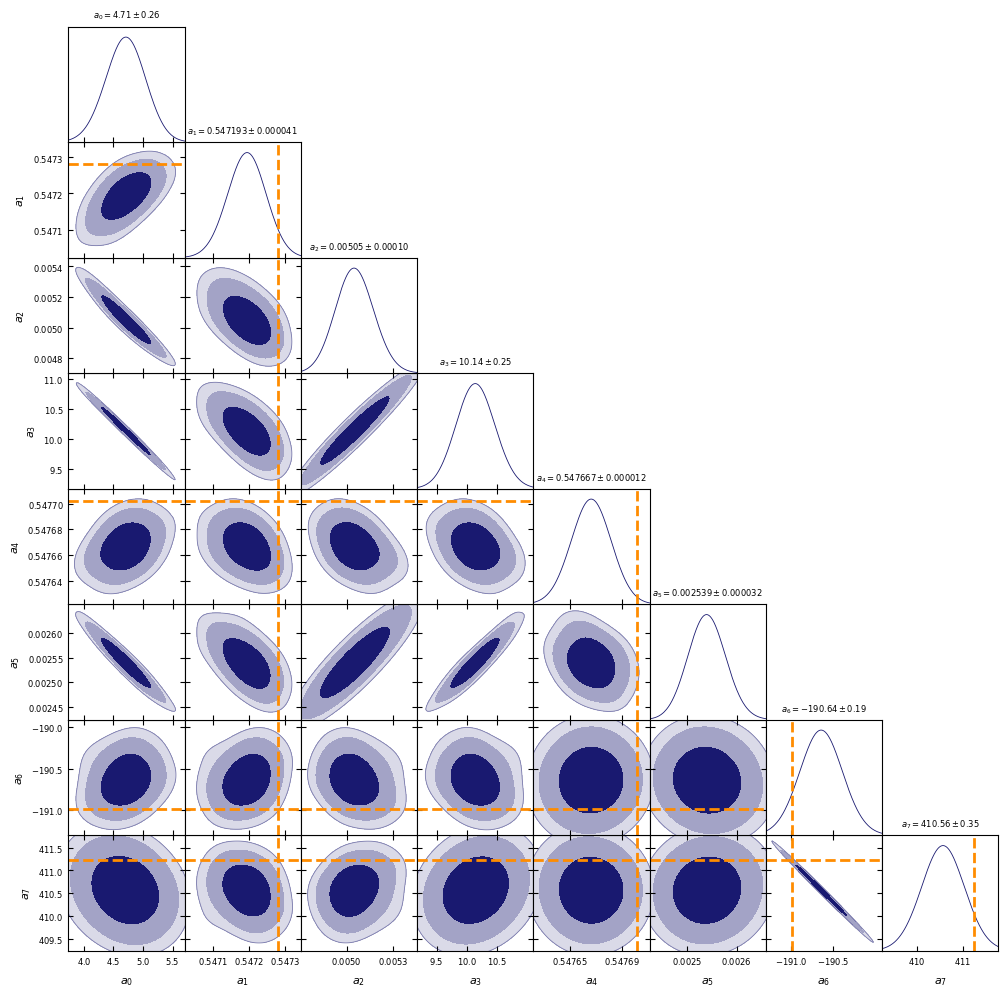

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples

# === Configuration ===
burn_in_fraction = 0.2  # discard initial 10% of samples
# Replace with your actual list of parameter names
Params_List = ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"]
dim = len(Params_List)

# Update with your actual Cobaya output prefix (without `.txt` or `.yaml`)
output_prefix = "stats/chains/eta/poly_deg7"  # Adjust if needed

# Load the MCMC samples
samples = loadMCSamples(output_prefix, settings={'ignore_rows': burn_in_fraction})

# Extract best-fit for marker placement
raw_chain = np.loadtxt(output_prefix + ".1.txt")
raw_chain = raw_chain[int(burn_in_fraction * raw_chain.shape[0]):]  # Apply burn-in
logpost = raw_chain[:, 1]  # log-posterior values
params = raw_chain[:, 2:2+dim]  # skip weight and logpost
best_index = np.argmax(logpost)
best_fit_params = params[best_index]

# Create triangle plot
plotter = gdplt.get_subplot_plotter()
plotter.settings.figure_legend_frame = False
plotter.settings.num_plot_contours = 3
plotter.settings.axes_fontsize = 10
plotter.settings.axes_labelsize = 12

# Adjust figure size for full box visibility
# plotter.settings.figure_width_inch = 12
plotter.settings.fig_width_inch = 12
plotter.settings.tight_layout = True
plotter.settings.tight_layout = [0.02, 0.02, 0.98, 0.98]  # [left, bottom, right, top]
# plotter.settings.tight_layout

# Generate triangle plot
plotter.triangle_plot([samples], Params_List,
                      filled=True,
                      contour_colors=['midnightblue'],
                      markers=best_fit_params,
                      marker_args={'c': 'darkorange', 'ls': '--', 'lw': 2},
                      title_limit=1)

plt.show()


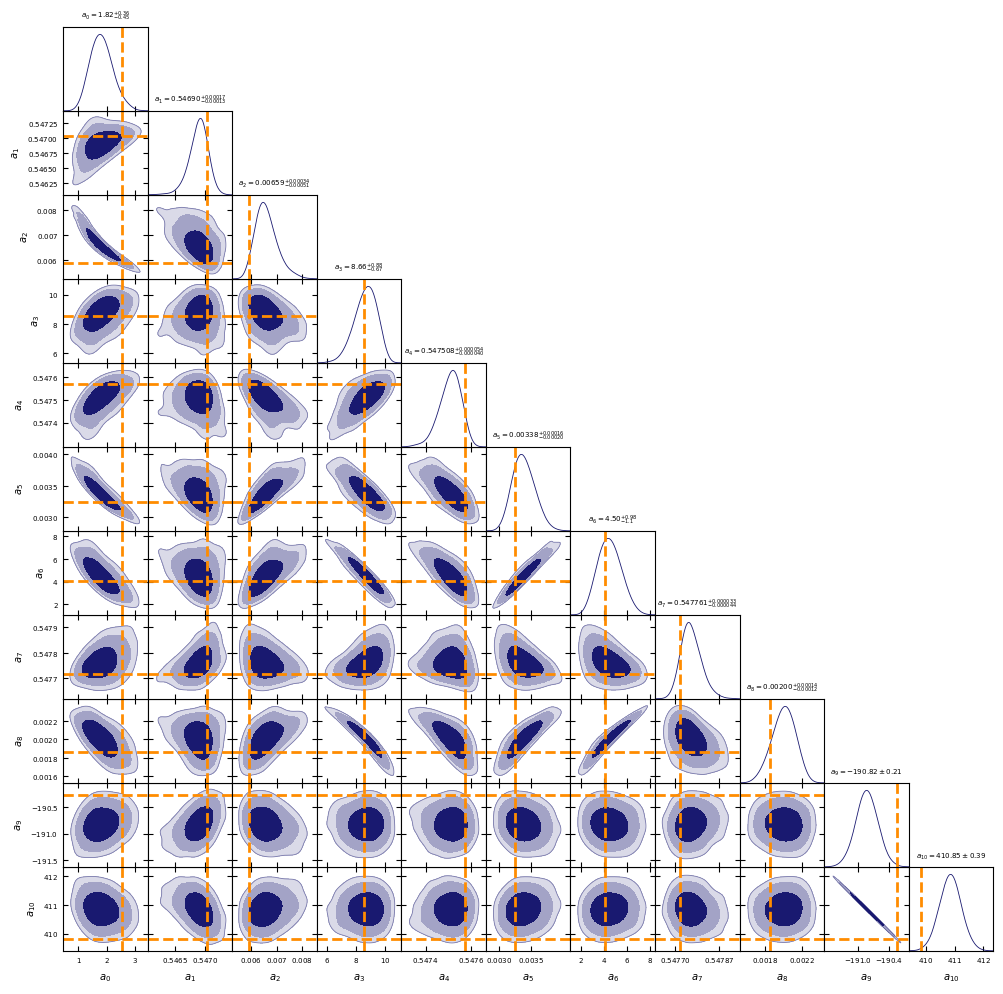

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples

# === Configuration ===
burn_in_fraction = 0.5  # discard initial 10% of samples
# Replace with your actual list of parameter names
Params_List = ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8", "a9", "a10"]
dim = len(Params_List)

# Update with your actual Cobaya output prefix (without `.txt` or `.yaml`)
output_prefix = "stats/chains/eta/poly_deg10"  # Adjust if needed

# Load the MCMC samples
samples = loadMCSamples(output_prefix, settings={'ignore_rows': burn_in_fraction})

# Extract best-fit for marker placement
raw_chain = np.loadtxt(output_prefix + ".1.txt")
raw_chain = raw_chain[int(burn_in_fraction * raw_chain.shape[0]):]  # Apply burn-in
logpost = raw_chain[:, 1]  # log-posterior values
params = raw_chain[:, 2:2+dim]  # skip weight and logpost
best_index = np.argmax(logpost)
best_fit_params = params[best_index]

# Create triangle plot
plotter = gdplt.get_subplot_plotter()
plotter.settings.figure_legend_frame = False
plotter.settings.num_plot_contours = 3
plotter.settings.axes_fontsize = 10
plotter.settings.axes_labelsize = 12

# Adjust figure size for full box visibility
# plotter.settings.figure_width_inch = 12
plotter.settings.fig_width_inch = 12
plotter.settings.tight_layout = True
plotter.settings.tight_layout = [0.02, 0.02, 0.98, 0.98]  # [left, bottom, right, top]
# plotter.settings.tight_layout

# Generate triangle plot
plotter.triangle_plot([samples], Params_List,
                      filled=True,
                      contour_colors=['midnightblue'],
                      markers=best_fit_params,
                      marker_args={'c': 'darkorange', 'ls': '--', 'lw': 2},
                      title_limit=1)

plt.show()


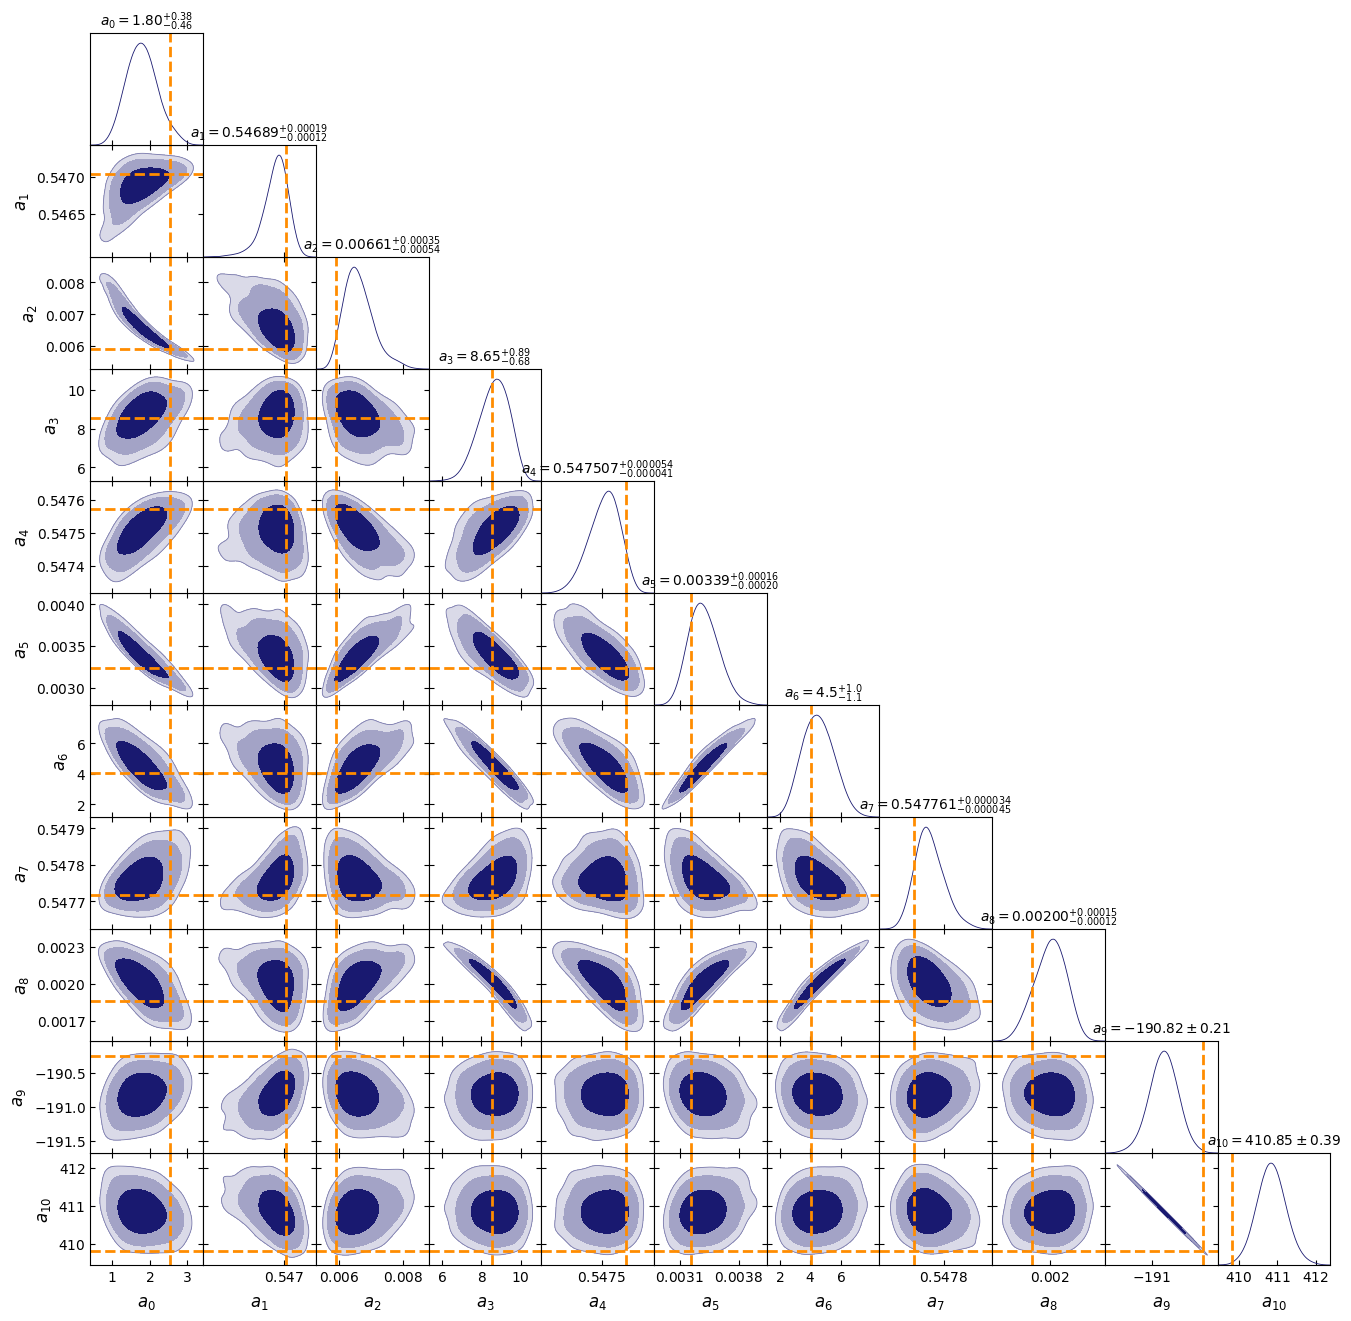

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples

# === Configuration ===
burn_in_fraction = 0.7  # Discard initial 50% of samples
output_prefix = "stats/chains/eta/poly_deg10"  # Cobaya output prefix

# Parameter names used internally in the chain
param_names = ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8", "a9", "a10"]

# LaTeX-formatted labels for nicer display
param_labels = [
    r"$A_1$", r"$\mu_1$", r"$\sigma_1$",
    r"$A_2$", r"$\mu_2$", r"$\sigma_2$",
    r"$A_3$", r"$\mu_3$", r"$\sigma_3$",
    r"$a_0$", r"$a_1$"
]

# Load the MCMC samples
samples = loadMCSamples(output_prefix, settings={'ignore_rows': burn_in_fraction})

# Extract best-fit values from the raw chain (after burn-in)
raw_chain = np.loadtxt(output_prefix + ".1.txt")
raw_chain = raw_chain[int(burn_in_fraction * raw_chain.shape[0]):]
logpost = raw_chain[:, 1]               # log-posterior column
params = raw_chain[:, 2:2+len(param_names)]
best_index = np.argmax(logpost)
best_fit_params = params[best_index]

# === Plotting ===
plotter = gdplt.get_subplot_plotter()
plotter.settings.figure_legend_frame = False
plotter.settings.num_plot_contours = 3
plotter.settings.axes_fontsize = 14
plotter.settings.axes_labelsize = 16

# Increase figure size
plotter.settings.fig_width_inch = 16
# plotter.settings.fig_ = 16  # for square figure
plotter.settings.tight_layout = True
plotter.settings.tight_layout = [0.02, 0.02, 0.98, 0.98]

# Generate triangle plot
plotter.triangle_plot(
    [samples],
    param_names,
    filled=True,
    contour_colors=['midnightblue'],
    markers=best_fit_params,
    marker_args={'c': 'darkorange', 'ls': '--', 'lw': 2},
    title_limit=1,
    param_labels=param_labels
)

plt.show()
